In [1]:
using Pkg,Statistics,Random,Printf,GZip,Knet,Plots,LinearAlgebra,Distributions,StatsBase, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10229829598189440886\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12449725749025348155\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/6cbf0fd219fa6416ec9b47399ab16ea685b891e3-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-10229829598189440886\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

## Generate training data

In [2]:
Random.seed!(4);
Range=3.0; # range of the x values for the target Gaussian function
Incr = 0.03; # Number of training examples = 3.0/0.03 = 100
Noise_std=0.1; # add noise on the Gaussian function

In [3]:
# generate the data from which we'll learn the Gaussian function
# obligatory arguments listed before ";" while optional arguments come after ";".
function gen_noisy_gaussian(;range=1.0,noise=0.1)
    x = collect(-Range:Incr:Range)
    y = exp.(-x.^2) + randn(length(x))*noise; # additive gaussian noise
    return (x,y)
end
# output is two vectors x,y

gen_noisy_gaussian (generic function with 1 method)

In [4]:
(x_train,y_train) = gen_noisy_gaussian(range=Range,noise=Noise_std);
pop!(x_train);pop!(y_train);

In [5]:
Ntrain =length(x_train) # number of training data points

200

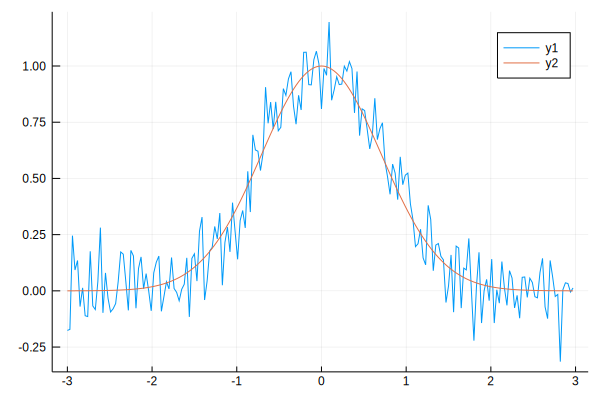

In [6]:
plot(x_train,[y_train,exp.(-x_train.^2)])

## Network + loss function

In [7]:
Batchsize = 10; # determines the degree of batch noise (smaller batchsize => larger noise)
RegWeight=0.001; # lambda for L2 regularization - sets the minimum of the Hessian eigenvalues
InitNorm = 0.5; # initial weight norm - not critical

In [8]:
Nweights = 7

7

In [9]:
function predict(w,x) # returns a row of predicted values for each sample in x
    return w[5:6]'*tanh.(w[1:2]*x' .+ w[3:4]) .+ w[7]
end

predict (generic function with 1 method)

In [10]:
# both x and y are ordered in columns per training data point
function sqloss(w,x,y)
    return mean(abs2,y'-predict(w,x))
end

function reg(w)
    return RegWeight*norm(w)^2
end

function loss(w,x,y)
    return sqloss(w,x,y) + reg(w)
end

loss (generic function with 1 method)

## Gradient

In [11]:
# grad() is a "functional" whose input and output is a function (loss). 
# The output function takes the same arguments as the input function.
# Requires input to be a scalar function and evaluates the gradient wrt elements of the first argument.
# Let ∇f = grad(f). f = f(x,y,z) => ∇f(x,y,z) = ∇ₓf with identical structure as x
lossgradient = grad(loss)
sqlossgradient = grad(sqloss)
reggradient = grad(reg)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(reg),Int64,Bool}}) (generic function with 1 method)

In [12]:
# calculate gradient at the initial w
# dw has dimensions of w: each weight wᵢ is replaced with the ∂/∂wᵢ
@show w = randn(Nweights)
dw = lossgradient(w,x_train,y_train)

w = randn(Nweights) = [0.504805, 0.532632, 0.281184, -0.333792, 2.80494, 0.147718, -0.882034]


7-element Array{Float64,1}:
  7.848550098894413  
  0.29795664798000243
 -4.059705674914736  
 -0.04816032359271255
  1.9653841432168029 
  2.573345280474825  
 -1.5053458677571874 

## Training function (with replacement)

In [13]:
function batchtrain!(w,lr)
perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
x = [x_train[n] for n in perm]
y = [y_train[n] for n in perm]
# calculate gradient over the batch
dw = lossgradient(w,x,y);
#update weights
    w .-= lr*dw # "." does broadcasting. `this is the same as for i=1:Nweights w[i] -= lr*dw[i] end
return w
end

batchtrain! (generic function with 1 method)

## Initial training run

In [14]:
Random.seed!(2);
w = rand(Nweights); w/= norm(w)/InitNorm
Nmarkov = 10000; # For a quick training run
η = 0.01; # Learning rate

In [15]:
# Initial run - trajectory stored in w_training
w_training = zeros(Nweights,Nmarkov)
time0 = time()
for n = 1:Nmarkov
    w_training[:,n] = batchtrain!(w,η)
end
time()-time0

2.831496000289917

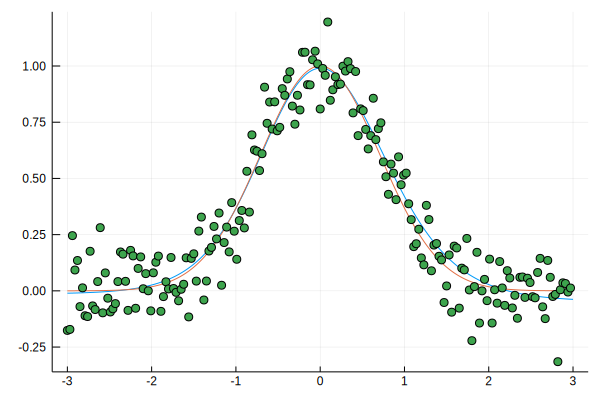

In [16]:
# Checking if the training worked. Compare the learned function with the actual gaussian
xplot=collect(-Range:0.01:Range)
# plot the converged function, the initial gaussian and the noisy training samples
plot(xplot,[predict(w,xplot)',exp.(-xplot.^2)]);
scatter!(x_train,y_train,leg=false)

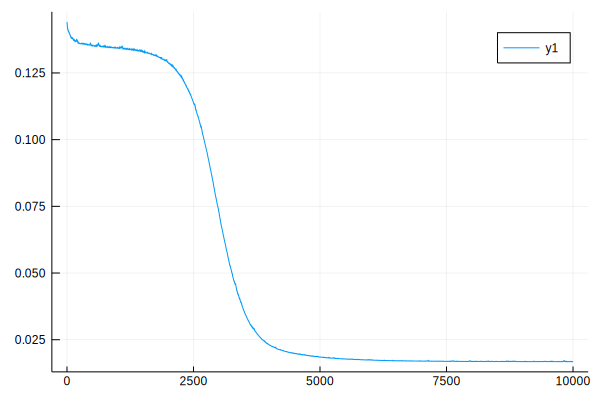

In [17]:
# Plot loss
SamplingRate=min(1,div(Nmarkov,1000));
x = collect(1:SamplingRate:Nmarkov);
y = [loss(w_training[:,i],x_train,y_train) for i in x];
#plot(x,y)
plot(x,y
#    ,xaxis=:log10
#    ,yaxis=:log10
    ) # can also plot in log-log scale

## Diffusion, Hessian, Covariance Matrices

In [18]:
function diffusionmatrix(w,xt,yt,Nb,lr) # Nb = batch size
    Nweights = length(w) # number of weights, that is, dimensions of the diffusion tensor
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    V = zeros(Nweights,Nt) # initialize the diffusion matrix
    for i=1:Nt
        x=xt[i]
        y=yt[i]
        V[:,i] = lossgradient(w,[x],[y])
    end
    V /= Nt;
    dL = sqlossgradient(w,xt,yt);
    
    return lr^2 * prefac * (Nt*V*V' - dL*dL')
end

diffusionmatrix (generic function with 1 method)

In [19]:
# Calculate the diffusion tensor by sampling the noise
function diffusionmatrix_num(w,n,lr) # n: number of samples used for estimation
    wlist = zeros(Nweights,n)
    
    for i=1:n
        ww = copy(w)       
        wlist[:,i] = batchtrain!(ww,lr)
    end

    # subtract mean
    wlist .-= sum(wlist[:,i] for i=1:n)/n

    D = zeros(Nweights,Nweights)
    for α=1:Nweights
        for β=1:Nweights
            for i=1:n
                D[α,β] += wlist[α,i]*wlist[β,i]
            end
            D[α,β] /= n;
        end
    end
    return 0.5*D
end

diffusionmatrix_num (generic function with 1 method)

In [20]:
# To calculate the Hessian, define a scalar function returning ∂L/∂wⱼ
function lossgradj(w,x,y,j)
    return lossgradient(w,x,y)[j]
end

lossgradj (generic function with 1 method)

In [21]:
# Define the function returning ∂²L/∂wᵢ∂wⱼ for all i, given j (a column of the Hessian)
lossgradgrad = grad(lossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(lossgradj),Int64,Bool}}) (generic function with 1 method)

In [22]:
function hessianmatrix(w,x,y)
    Nw = length(w);
    Hess = zeros(Nw,Nw);
    for j=1:Nw
        Hess[:,j] = lossgradgrad(w,x,y,j)
    end
    return Hess
end

hessianmatrix (generic function with 1 method)

In [23]:
# This calculation is from Michael's overleaf notes:
# https://www.overleaf.com/2523873322bvvnxpwnskfk
function covariancematrix(D,H,lr) # is a function of the learning rate
    F = eigen(H);
    h = F.values
    O = F.vectors
    Nw = length(h)
    ODO = O'*D*O;
    Delta = zeros(Nw,Nw);
    for i=1:Nw
        for j=1:Nw
            Delta[i,j] = ODO[i,j]/(h[i]+h[j])
        end
    end
    return (2/lr)*O*Delta*O'
end

covariancematrix (generic function with 1 method)

### Use Newton's Method to find the minimum of loss

In [24]:
# Using Newton's method get the the true minimum of the full loss function
w = w_training[:,end];
# implement Newton's method to find the true minimum. 4 steps are enough!
for n=1:10
    Hess = hessianmatrix(w,x_train,y_train)
    gradw = lossgradient(w,x_train,y_train)
    dw = inv(Hess)*gradw
    for i=1:Nweights
        w[i] -= dw[i]
    end
end
wmin = w[:,1]

7-element Array{Float64,1}:
 -1.1226377819634539  
  1.2309808003009546  
  0.6237242066102502  
  0.6636374755671666  
  0.9024106741830753  
  0.8857884398284765  
 -0.026789678210916514

In [25]:
lossgradient(wmin,x_train,y_train)

7-element Array{Float64,1}:
 -1.734723475976807e-18 
 -2.6454533008646308e-17
  1.1058862159352145e-17
  2.949029909160572e-17 
  7.134050294954619e-17 
 -5.0523821237824507e-17
  5.4630236966113355e-17

### Hessian at the loss minimum

In [26]:
Hessmin = hessianmatrix(wmin,x_train,y_train)

7×7 Array{Float64,2}:
  0.191185     0.0477188    0.184902    -0.00575416   -0.227777    0.349034      0.290515
  0.0477188    0.152251    -0.00575416  -0.159513     -0.288382    0.188115     -0.255211
  0.184902    -0.00575416   0.329763     0.161818      0.0007127   0.375311      0.533429
 -0.00575416  -0.159513     0.161818     0.291827      0.336862   -0.000504538   0.47856 
 -0.227777    -0.288382     0.0007127    0.336862      1.41088    -1.15104       0.379223
  0.349034     0.188115     0.375311    -0.000504538  -1.15104     1.46174       0.348845
  0.290515    -0.255211     0.533429     0.47856       0.379223    0.348845      2.002   

In [27]:
eigvals(Hessmin), norm(Hessmin)

([2.75878, 2.53553, 0.293597, 0.192422, 0.048197, 0.00595349, 0.00516699], 3.7636935681919423)

### Diffusion tensor at the loss minimum

In [28]:
# diffusion tensor at the loss minimum (using VV')
Dmin = diffusionmatrix(wmin,x_train,y_train,Batchsize,η)

7×7 Array{Float64,2}:
  1.74339e-8   5.32896e-9   1.54906e-8   -1.93927e-9  -2.59239e-8    3.50367e-8   2.68857e-8
  5.32896e-9   1.88831e-8  -1.99704e-9   -2.04497e-8  -3.63366e-8    2.25552e-8  -3.38932e-8
  1.54906e-8  -1.99704e-9   2.74216e-8    1.5485e-8   -2.40275e-11   3.30599e-8   4.98134e-8
 -1.93927e-9  -2.04497e-8   1.5485e-8     3.28789e-8   4.0503e-8    -5.15288e-9   5.37777e-8
 -2.59239e-8  -3.63366e-8  -2.40275e-11   4.0503e-8    1.65058e-7   -1.35824e-7   5.82879e-8
  3.50367e-8   2.25552e-8   3.30599e-8   -5.15288e-9  -1.35824e-7    1.59548e-7   1.39242e-8
  2.68857e-8  -3.38932e-8   4.98134e-8    5.37777e-8   5.82879e-8    1.39242e-8   2.20289e-7

In [29]:
# compare with D calculated numerically
Dmin_num = diffusionmatrix_num(wmin,10000,η);
Dmin_num ./ Dmin

7×7 Array{Float64,2}:
 0.998946  1.00997    0.979658  1.20048     1.00075   0.984078  0.98569 
 1.00997   1.01102    1.01746   1.01465     1.01018   1.0072    0.99217 
 0.979658  1.01746    0.980171  0.983749  -20.6921    0.965412  0.988674
 1.20048   1.01465    0.983749  1.0121      1.02569   1.18373   0.994235
 1.00075   1.01018  -20.6921    1.02569     0.998579  0.98933   1.01347 
 0.984078  1.0072     0.965412  1.18373     0.98933   0.980775  0.901911
 0.98569   0.99217    0.988674  0.994235    1.01347   0.901911  0.989757

In [30]:
@show isapprox(Dmin_num,Dmin, rtol=0.01)
@show isapprox(Dmin_num,Dmin, rtol=0.02)

isapprox(Dmin_num, Dmin, rtol=0.01) = false
isapprox(Dmin_num, Dmin, rtol=0.02) = true


true

### Covariance matrix as a function of Hessian and Diffusion matrix

In [31]:
Covmin = covariancematrix(Dmin,Hessmin,η)

7×7 Array{Float64,2}:
  7.17113e-6   1.76395e-7   9.69501e-7  -4.36648e-7  -1.24584e-6  -7.20727e-7   5.16229e-7
  1.76395e-7   9.53257e-6  -2.00778e-7  -2.7168e-6    5.30452e-7   6.42348e-7  -1.02505e-7
  9.69501e-7  -2.00778e-7   5.90928e-6  -8.52919e-7   2.04093e-6   2.09795e-6  -7.07494e-8
 -4.36648e-7  -2.7168e-6   -8.52919e-7   7.84851e-6   2.27483e-6   2.28712e-6  -1.36924e-7
 -1.24584e-6   5.30452e-7   2.04093e-6   2.27483e-6   8.12191e-6  -3.33188e-6   8.25478e-7
 -7.20727e-7   6.42348e-7   2.09795e-6   2.28712e-6  -3.33188e-6   8.09326e-6  -1.04931e-6
  5.16229e-7  -1.02505e-7  -7.07494e-8  -1.36924e-7   8.25478e-7  -1.04931e-6   1.09935e-5

In [32]:
# verify that the math is right: HC+CH = (2/η)D
norm(Hessmin*Covmin + Covmin*Hessmin - (2/η)*Dmin) # should be zero

3.80252465584018e-19

### Derivative of the diffusion tensor

In [33]:
# construct a scalar function returning each element of the loss gradient
# sqloss is the loss without the regularization part.
function sqlossgradj(w,x,y,j)
    return sqlossgradient(w,x,y)[j]
end

sqlossgradj (generic function with 1 method)

In [34]:
# returns ∇(∂L/∂wⱼ)
sqlossgradgrad = grad(sqlossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(sqlossgradj),Int64,Bool}}) (generic function with 1 method)

In [35]:
# Calculate ∇D. ∇D[i,j,k] ≡ ∂D[j,k]/∂wᵢ

function gradkdiffij(w,xt,yt,Nb,lr)
    Nweights = length(w) 
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    ∇D = zeros(Nweights,Nweights,Nweights)
    dL = sqlossgradient(w,xt,yt)
    ddL = hessianmatrix(w,xt,yt) - 2*RegWeight*diagm(0=>ones(Nweights)) # nly sqloss()'s 2nd derivative
    for n=1:Nt
        x=xt[n]
        y=yt[n]
        
        dLn = sqlossgradient(w,[x],[y])
        
        ddLn = zeros(Nweights,Nweights);
        for i=1:Nweights
            ddLn[:,i] = sqlossgradgrad(w,[x],[y],i)
        end
        
        for i=1:Nweights
            for j=1:Nweights
                ∇D[:,i,j] += ddLn[:,i]*dLn[j] + ddLn[:,j]*dLn[i]
            end
        end
    end
    ∇D /= Nt
    
    for i=1:Nweights
        for j=1:Nweights
            ∇D[:,i,j] -= ddL[:,i]*dL[j] + dL[i]*ddL[:,j]
        end
    end

    return lr^2 * prefac * ∇D
end

gradkdiffij (generic function with 1 method)

In [36]:
# Calculate ∇D using finite difference for validation
function gradkdiffij_num(w,xt,yt,Nb,lr;eps=1e-5)
    Nw = length(w) 
    D = diffusionmatrix(w,xt,yt,Nb,lr);
    dD = zeros(Nw,Nw,Nw);
    for i=1:Nw
        dw = zeros(Nw);
        dw[i] += eps
        dD[i,:,:] = diffusionmatrix(w+dw,xt,yt,Nb,lr)-diffusionmatrix(w-dw,xt,yt,Nb,lr);
    end
    dD /= 2*eps
    
    return dD
end

gradkdiffij_num (generic function with 1 method)

In [37]:
# Calculate ∇[inv(D)] using finite difference for validation
function gradkinvdiffij_num(w,xt,yt,Nb,lr;eps=1e-8)
    Nw = length(w) 
    dDinv = zeros(Nw,Nw,Nw);
    for i=1:Nw
        dw = zeros(Nw);
        dw[i] += eps
        dDinv[i,:,:] = inv(diffusionmatrix(w+dw,xt,yt,Nb,lr))-inv(diffusionmatrix(w-dw,xt,yt,Nb,lr));
    end
    dDinv /= 2*eps
    
    return dDinv
end

gradkinvdiffij_num (generic function with 1 method)

In [38]:
Random.seed!(5)
w = randn(Nweights)
@time ∇D = gradkdiffij(w,x_train,y_train,Batchsize,η);

  1.549454 seconds (2.67 M allocations: 140.779 MiB, 6.56% gc time)


norm(∇D - ∇D_num) / norm(∇D) = 0.0013823398559993354


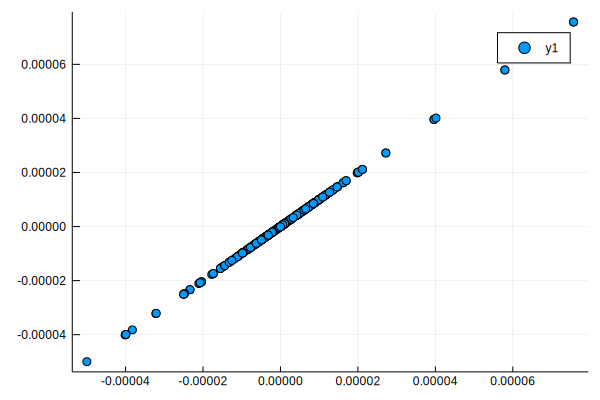

In [39]:
∇D_num = gradkdiffij_num(w,x_train,y_train,Batchsize,η,eps=1e-6);
@show norm(∇D-∇D_num)/norm(∇D)
scatter(reshape(∇D,Nweights^3,1),reshape(∇D_num,Nweights^3,1))

In [40]:
D = diffusionmatrix(w,x_train,y_train,Batchsize,η)
invD = inv(D)
∇invD = zeros(Nweights,Nweights,Nweights)
for n=1:Nweights
    ∇invD[n,:,:] = -invD*∇D_num[n,:,:]*invD # = ∂D⁻¹/∂w_n # this works
#    ∇invD[n,:,:] = -invD*∇D[n,:,:]*invD # = ∂D⁻¹/∂w_n # this doesn't, although ∇D and ∇D_num agree to within 0.1%
end
∇invD_num = gradkinvdiffij_num(w,x_train,y_train,Batchsize,η,eps=1e-8);
norm(∇invD-∇invD_num)/norm(∇invD)

0.034310528240970875

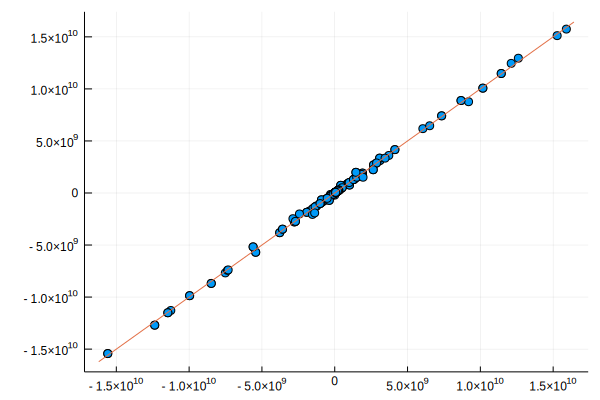

In [41]:
# What is the problem with ∇invD[n,:,:] = -invD*∇D[n,:,:]*invD in the previous cell?
scatter(reshape(∇invD,Nweights^3,1),reshape(∇invD_num,Nweights^3,1))
g(x)=x
plot!(g,leg=false)

In [42]:
eigD = eigvals(Dmin/η^2)

7-element Array{Float64,1}:
 0.0033283735879252284 
 0.002550161546128809  
 0.0003138688521341562 
 0.00017864308486948436
 4.0403455659777385e-5 
 3.5251408031489637e-6 
 1.40981053697789e-7   

In [43]:
count(x -> (x > 1e-10),eigvals(Dmin))

6

## Thermal SGD - with C = lr\*T\*inv(Dmin)

In [44]:
function thermaltrain!(w,lr,T)
    perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
    x = [x_train[n] for n in perm]
    y = [y_train[n] for n in perm]
# gradient calculated on the batch
    gradw = lossgradient(w,x,y)
# calculate C
    D = Symmetric(diffusionmatrix(w,x_train,y_train,Batchsize,lr))
    k = count(x -> (x > 1e-6),eigvals(D/η^2)) # pick eigenvalues greater than 1e-10
    ef = eigen(D, Nweights-k+1:Nweights) #k largest eigenvalues/vectors
    Λ = reverse(ef.values, dims=1) # kxk matrix of top k eigenvalues in descending order
    U = reverse(ef.vectors,dims=2) # 7 x k matrix
    C = lr*T*U*Diagonal(1.0./Λ)*U'
# update w
    dw = C*gradw # + q
    for i=1:length(w)
        w[i] -= lr*dw[i]
    end

    return w
end

thermaltrain! (generic function with 1 method)

## Thermal learning

In [50]:
Random.seed!(2) # Verified that the results don't change for different seeds.
w = rand(Nweights); w/= norm(w)/InitNorm;
w_init = copy(w)
D_init = diffusionmatrix(w,x_train,y_train,Batchsize,η); eigvals(D_init)

7-element Array{Float64,1}:
  3.296450930207046e-6  
  2.7468045693074504e-7 
  1.2225337308453585e-9 
  6.453996093274849e-11 
  8.958209190457933e-13 
  6.998436238549569e-16 
 -1.4259577480783606e-13

In [51]:
Nmarkov=5*10^3

5000

In [53]:
mult_max=20
w_ss = zeros(mult_max,Nweights,Nmarkov)
xlims = Nmarkov*ones(Int,mult_max)
for mult=1:mult_max
    w = copy(w_init)
    Temp = (1.2^(mult-10))*1e-4
    @show mult,Temp
    n=1
    w_ss[mult,:,n] = copy(w)
    los=1.0
    while(n<Nmarkov && los>0.018)
        n += 1
        w_ss[mult,:,n] = thermaltrain!(w,η,Temp)
        if (n%100==1)
            los = loss(w,x_train,y_train)
            @show n,los
        end
    end
    xlims[mult]=n
end

(mult, Temp) = (1, 1.9380669946781493e-5)
(n, los) = (101, 0.10640479181929327)
(n, los) = (201, 0.07646139210426856)
(n, los) = (301, 0.062239398240670325)
(n, los) = (401, 0.05138105431827861)
(n, los) = (501, 0.04048658407300147)
(n, los) = (601, 0.030304278570245518)
(n, los) = (701, 0.021752598244505678)
(n, los) = (801, 0.017017768528498185)
(mult, Temp) = (2, 2.325680393613779e-5)
(n, los) = (101, 0.09987006703423863)
(n, los) = (201, 0.07073611329393162)
(n, los) = (301, 0.05448285104064035)
(n, los) = (401, 0.04090878332149824)
(n, los) = (501, 0.03006515592667472)
(n, los) = (601, 0.02044162122930624)
(n, los) = (701, 0.01692323376702875)
(mult, Temp) = (3, 2.7908164723365347e-5)
(n, los) = (101, 0.09142141916466487)
(n, los) = (201, 0.0648616823946262)
(n, los) = (301, 0.0491022790302867)
(n, los) = (401, 0.03427964819729359)
(n, los) = (501, 0.02104706199486967)
(n, los) = (601, 0.017013750588373733)
(mult, Temp) = (4, 3.348979766803842e-5)
(n, los) = (101, 0.08247260522184

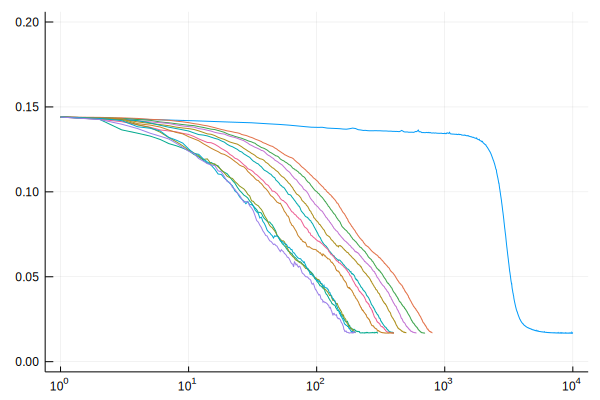

In [107]:
# Plot loss
# SGD loss
sr=10
Ntraining = length(w_training[1,:])
y_sgd = [loss(w_training[:,i],x_train,y_train) for i=1:sr:Ntraining];
myplot = plot(collect(1:sr:Ntraining),y_sgd) # can also plot in log-log scale

# Thermal loss
for mult=1:mult_max-9
    x = collect(1:xlims[mult])
    y = [loss(w_ss[mult,:,i],x_train,y_train) for i in x];
    myplot = plot!(x,y,xlim=[1,10*Nmarkov]
        ,ylim=[0,0.2]
        ,xaxis=:log
        ,leg=false)
end
myplot

## Fastest SGD

In [104]:
Random.seed!(2);
w = rand(Nweights); w/= norm(w)/InitNorm
Nmarkov = 1000; # For a quick training run
η = 0.42; # Learning rate

In [105]:
# Initial run - trajectory stored in w_training
w_fastestSGD = zeros(Nweights,Nmarkov)
time0 = time()
for n = 1:Nmarkov
    w_fastestSGD[:,n] = batchtrain!(w,η)
end
time()-time0

0.25370121002197266

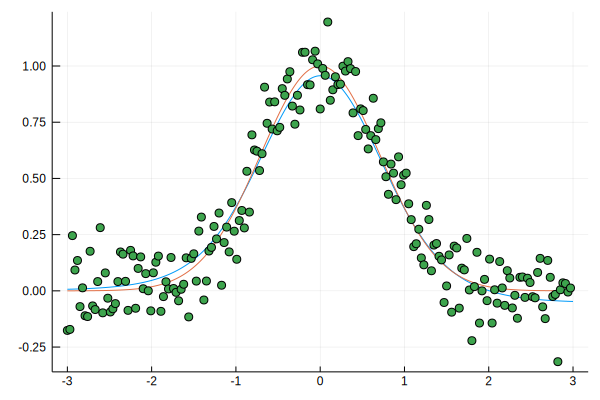

In [106]:
# Checking if the training worked. Compare the learned function with the actual gaussian
xplot=collect(-Range:0.01:Range)
# plot the converged function, the initial gaussian and the noisy training samples
plot(xplot,[predict(w,xplot)',exp.(-xplot.^2)]);
scatter!(x_train,y_train,leg=false)

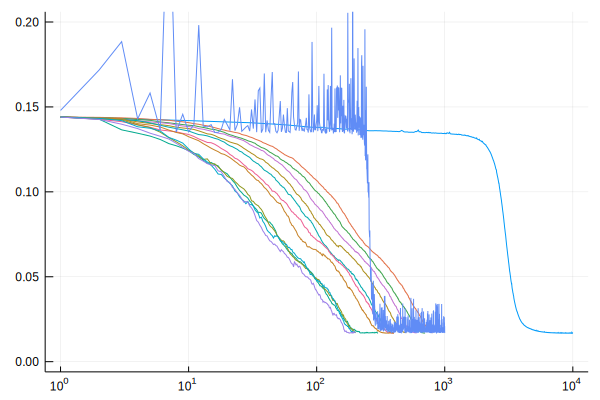

In [113]:
# Plot loss
# SGD loss
sr=10
Ntraining = length(w_training[1,:])
y_sgd = [loss(w_training[:,i],x_train,y_train) for i=1:sr:Ntraining];
myplot = plot(collect(1:sr:Ntraining),y_sgd) # can also plot in log-log scale

# Thermal loss
for mult=1:mult_max-9
    x = collect(1:xlims[mult])
    y = [loss(w_ss[mult,:,i],x_train,y_train) for i in x];
    myplot = plot!(x,y
        ,xlim=[1,10*Nmarkov]
        ,ylim=[0,0.2]
        ,xaxis=:log
        ,leg=false)
end
myplot

NfastestSGD = length(w_fastestSGD[1,:])
y_fastestSGD = [loss(w_fastestSGD[:,i],x_train,y_train) for i=1:NfastestSGD];
plot!(collect(1:NfastestSGD),y_fastestSGD
    ,xaxis=:log10
    )

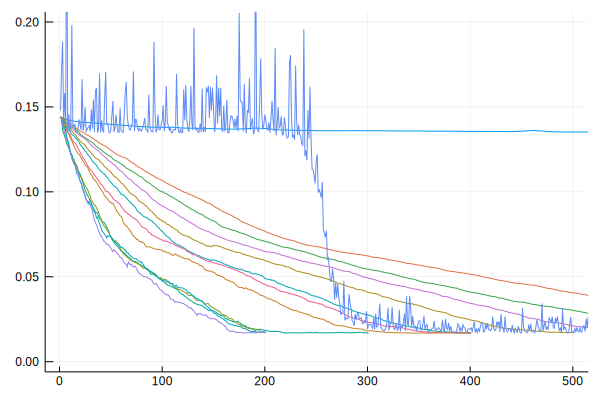

In [112]:
# Plot loss
# SGD loss
sr=10
Ntraining = length(w_training[1,:])
y_sgd = [loss(w_training[:,i],x_train,y_train) for i=1:sr:Ntraining];
myplot = plot(collect(1:sr:Ntraining),y_sgd) # can also plot in log-log scale

# Thermal loss
for mult=1:mult_max-9
    x = collect(1:xlims[mult])
    y = [loss(w_ss[mult,:,i],x_train,y_train) for i in x];
    myplot = plot!(x,y
#        ,xlim=[1,10*Nmarkov]
        ,xlim=[1,500]
        ,ylim=[0,0.2]
#        ,xaxis=:log
        ,leg=false)
end
myplot

NfastestSGD = length(w_fastestSGD[1,:])
y_fastestSGD = [loss(w_fastestSGD[:,i],x_train,y_train) for i=1:NfastestSGD];
plot!(collect(1:NfastestSGD),y_fastestSGD
#    ,xaxis=:log10
    ) # can also plot in log-log scale